In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import get_train_data
from problem import get_test_data
from catboost import CatBoost, CatBoostClassifier

In [2]:
def compute_rolling_std(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std"])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_mean(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "mean"])
    X_df[name] = X_df[feature].rolling(time_window, center=center).mean()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, center)
    X_df = compute_rolling_std(X_df, feature, time_window, center)
    return X_df

def clip_column(X_df, column, min, max):
    X_df[column] = X_df[column].clip(min, max)
    return X_df

def transform(X):
    X = clip_column(X, 'Beta', 0, 250)
    X = clip_column(X, 'Np_nl', 0, 100)
    X = clip_column(X, 'Np', 0, 500)

    for i in ["2h", "6h", "12h", "24h", "48h"]:
        for j in ["B", "Beta", "RmsBob", "Vx", "Vth", "Range F 13", "Range F 9", "Range F 2", "V"]:
            X = compute_rolling_variables(X, j, i)
            X = X.copy()

    return X

In [3]:
X, y = get_train_data()
Xt, yt = get_test_data()
X

,B,Bx,Bx_rms,By,By_rms,Bz,Bz_rms,Na_nl,Np,Np_nl,...,Range F 8,Range F 9,V,Vth,Vx,Vy,Vz,Beta,Pdyn,RmsBob
1997-10-01 00:00:00,6.584763,3.753262,2.303108,0.966140,2.602693,-5.179685,2.668414,2.290824,23.045732,24.352797,...,2.757919e+09,2.472087e+09,378.313934,80.613098,-351.598389,-138.521454,6.956387,7.641340,5.487331e-15,0.668473
1997-10-01 00:10:00,6.036456,0.693559,1.810752,-0.904843,2.165570,-1.944006,2.372931,2.119593,23.000492,20.993362,...,3.365612e+09,3.087122e+09,350.421021,69.919327,-331.012146,-110.970787,-21.269474,9.149856,4.783776e-15,0.753848
1997-10-01 00:20:00,5.653682,-4.684786,0.893058,-2.668830,0.768677,1.479302,1.069266,2.876815,20.676191,17.496399,...,1.675611e+09,1.558640e+09,328.324493,92.194435,-306.114899,-117.035202,-13.018987,11.924199,3.719768e-15,0.282667
1997-10-01 00:30:00,5.461768,-4.672382,1.081638,-2.425630,0.765681,1.203713,0.934445,2.851195,20.730188,16.747108,...,1.589037e+09,1.439569e+09,319.436859,94.230705,-298.460938,-110.403969,-20.350492,16.032987,3.525211e-15,0.304713
1997-10-01 00:40:00,6.177846,-5.230110,1.046126,-2.872561,0.635256,1.505010,0.850657,3.317076,20.675701,17.524536,...,1.812308e+09,1.529260e+09,327.545929,89.292595,-307.303070,-111.865845,-12.313167,10.253789,3.694283e-15,0.244203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31 23:10:00,3.965134,-2.384035,0.441219,2.217838,0.487077,-1.381152,0.631304,0.109651,6.902308,6.687846,...,1.253163e+09,1.878204e+09,349.519318,37.452972,-349.390076,-0.107922,-4.417354,1.304273,1.411728e-15,0.247082
2007-12-31 23:20:00,4.355162,-3.164303,0.282613,-0.074648,0.437347,-2.482400,0.216370,0.109274,6.674006,6.294575,...,1.260142e+09,1.838964e+09,345.761414,36.232159,-345.545410,9.316546,0.370024,0.982693,1.335080e-15,0.139195
2007-12-31 23:30:00,4.268256,-3.642998,0.205906,0.114703,0.418586,-1.986862,0.191687,0.110750,6.519631,5.415397,...,1.172253e+09,1.679522e+09,342.465698,36.020718,-342.284668,8.631990,3.142477,0.989657,1.278599e-15,0.124656
2007-12-31 23:40:00,4.194678,-3.701024,0.137178,0.903285,0.256621,-1.420870,0.148968,0.117862,6.421871,5.499616,...,1.051353e+09,1.644286e+09,343.498444,35.154537,-343.367157,5.641228,-2.413303,0.958408,1.267188e-15,0.080642


In [4]:
X = X.rolling('1h', center=True).mean(engine='numba')
X

,B,Bx,Bx_rms,By,By_rms,Bz,Bz_rms,Na_nl,Np,Np_nl,...,Range F 8,Range F 9,V,Vth,Vx,Vy,Vz,Beta,Pdyn,RmsBob
1997-10-01 00:00:00,5.934167,-1.227587,1.522139,-1.258291,1.575655,-1.110169,1.761264,2.534607,21.863151,19.897417,...,2.347045e+09,2.139354e+09,344.124077,84.239391,-321.796593,-119.232853,-11.920642,11.187095,4.379022e-15,0.502425
1997-10-01 00:10:00,5.982903,-2.028092,1.426936,-1.581145,1.387575,-0.587133,1.579143,2.691101,21.625661,19.422840,...,2.240097e+09,2.017336e+09,340.808447,85.250032,-318.897888,-117.759451,-11.999147,11.000434,4.242074e-15,0.450781
1997-10-01 00:20:00,5.936574,-2.480120,1.335389,-1.833221,1.303056,-0.409026,1.492179,2.791557,21.927770,19.424922,...,2.200525e+09,1.990796e+09,339.783010,86.382195,-319.232437,-110.685337,-9.855624,11.350376,4.265898e-15,0.424498
1997-10-01 00:30:00,5.811932,-3.137210,1.433746,-2.625904,1.349878,0.081341,1.554719,2.716108,24.375617,21.063027,...,3.245068e+09,3.610184e+09,348.508519,83.213191,-331.560399,-93.590134,-14.695112,13.373355,5.336818e-15,0.483004
1997-10-01 00:40:00,6.019678,-3.233967,1.874856,-3.509980,1.515371,0.099267,1.891269,2.452460,26.924766,21.680595,...,4.412072e+09,5.339718e+09,373.336655,79.404324,-356.330765,-66.666940,-13.587399,12.655692,7.593736e-15,0.528368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31 23:10:00,4.209683,-2.549681,0.316266,1.797238,0.360921,-0.989099,0.365144,0.109918,6.733401,6.254714,...,1.259108e+09,1.856639e+09,347.771159,35.556176,-347.511922,2.470167,-5.719888,1.027302,1.363746e-15,0.156172
2007-12-31 23:20:00,4.186328,-3.008573,0.264746,1.331615,0.333983,-1.438010,0.307394,0.112951,6.602115,5.996941,...,1.180738e+09,1.773300e+09,346.380061,35.626398,-346.204849,4.731171,-2.382770,1.022770,1.326010e-15,0.137566
2007-12-31 23:30:00,4.196017,-3.338288,0.232980,0.849873,0.352886,-1.718290,0.267004,0.114499,6.534994,5.807023,...,1.143749e+09,1.728862e+09,345.298950,35.996017,-345.139410,6.156389,-0.463193,1.029460,1.304005e-15,0.130055
2007-12-31 23:40:00,4.253737,-3.576851,0.180921,0.507882,0.319339,-1.802574,0.175929,0.115711,6.443166,5.586817,...,1.116395e+09,1.691526e+09,344.243858,35.631778,-344.076744,7.722467,0.525347,0.960757,1.277075e-15,0.100798


In [14]:
cat = CatBoostClassifier(iterations=300,
                                depth=5,
                                l2_leaf_reg=3,
                                loss_function='Logloss',
                                auto_class_weights='SqrtBalanced',
                                learning_rate=0.05,
                                logging_level='Silent',
                                task_type="CPU")

In [15]:
cat.fit(
    X,
    y=y,
    verbose=100,
    eval_set=(Xt, yt),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

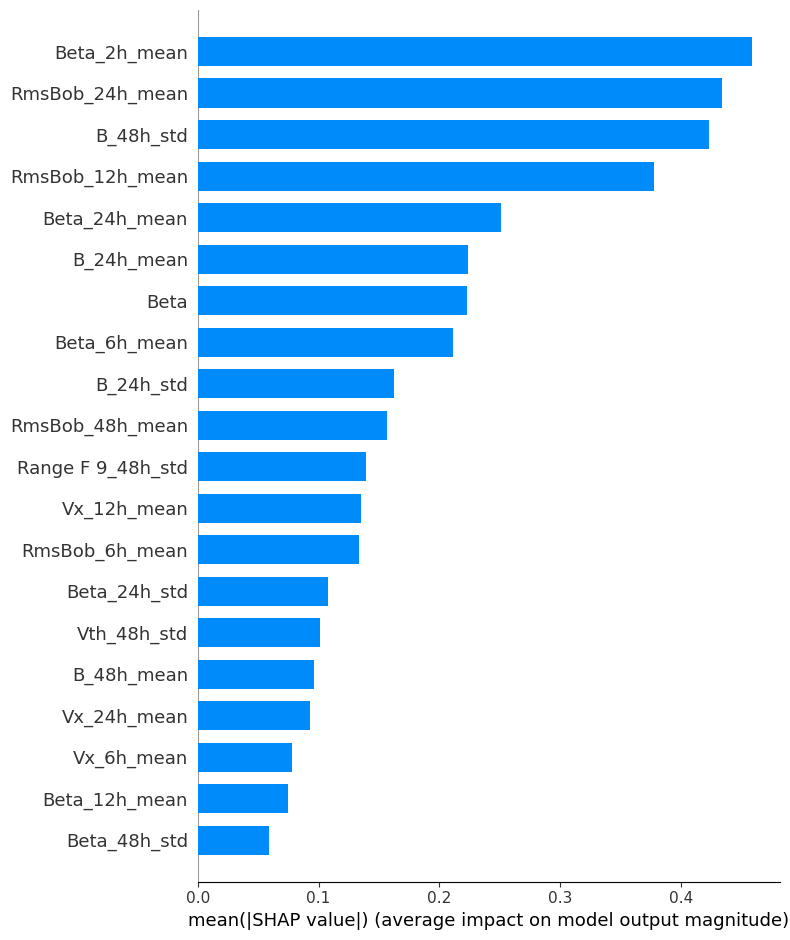

In [16]:
import shap
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type='bar', class_names=cat.classes_, feature_names=X.columns)